In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os
sys.path.append('/home/andy/Documents/software')
import getdata, sqlutilpy

import numpy as np, healpy as hp, h5py, pandas as pd
from scipy import stats, special, linalg, optimize
import scipy
import tqdm

# Plotting modules
import matplotlib.pyplot as plt, matplotlib
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [4]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [5]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

In [6]:
from astropy.coordinates import SkyCoord
import warnings
warnings.filterwarnings('ignore')

In [7]:
file = "gaia_unwise_sdss_b80"
filename="/data/asfe2/Projects/mwtrace_data/gaia/%s.h" % file
size = 'full'
# Load Sample
#keys = {'phot_g_mean_mag':'phot_g_mean_mag', 'parallax':'parallax', 'b':'b', 'parallax_error':'parallax_error', }
keys = ['source_id', 'phot_g_mean_mag', 'phot_g_corr', 'parallax','l', 'b', 'parallax_error', 'parallax_error_corr', 'zeropoint',
        'specobjid', 'class', 'bp_rp', 'phot_bp_rp_excess_factor', 'phot_bp_rp_excess_factor_c', 'w1', 'w2', 'ruwe']
sample = {};
for cardinal in ['south', 'north']:
    sample[cardinal]={}
    with h5py.File(filename, 'r') as hf:
        subset = ( ~np.isnan(hf[cardinal]['phot_g_corr'][...]) )
        subset = np.ones(len(hf[cardinal]['source_id']), dtype=bool)
        print('%d/%d' % (np.sum(subset), len(subset)))
        if size=='full': subsample = np.arange(np.sum(subset))
        else: subsample  = np.sort(np.random.choice(np.arange(np.sum(subset)), size=size, replace=False))
        for key in keys:
            sample[cardinal][key]=hf[cardinal][key][...][subset][subsample]
    sample[cardinal]['sinb'] = np.sin(np.deg2rad(sample[cardinal]['b']))
    sample[cardinal]['parallax_obs'] = sample[cardinal]['parallax']-sample[cardinal]['zeropoint']
    sample[cardinal]['m']  = sample[cardinal]['phot_g_corr'].copy()
    
    sample[cardinal]['M'] = sample[cardinal]['m'] + 5*(np.log10(sample[cardinal]['parallax_obs'])-2)

942006/942006
905216/905216


In [8]:
excess_c = {}
with h5py.File(filename, 'r') as hf:
    for cardinal in ['south', 'north']:
        excess_c[cardinal]=hf[cardinal]['phot_bp_rp_excess_factor_c'][...]

# 1) Given G magnitude

In [9]:
for cardinal in ['north', 'south']:
    sample[cardinal]['select1'] = ~np.isnan(sample[cardinal]['phot_g_corr']) &  ~np.isnan(sample[cardinal]['parallax'])
    print(f"{cardinal} No G {np.sum(np.isnan(sample[cardinal]['phot_g_mean_mag']))}")
    print(f"{cardinal} No G corrected: {np.sum(np.isnan(sample[cardinal]['phot_g_corr']))}")
    print(f"{cardinal} No parallax: {np.sum(np.isnan(sample[cardinal]['parallax']))}")
    print(f"{cardinal} No G or parallax {np.sum(np.isnan(sample[cardinal]['phot_g_mean_mag']) & np.isnan(sample[cardinal]['parallax']))}")

north No G 814
north No G corrected: 814
north No parallax: 207365
north No G or parallax 625
south No G 875
south No G corrected: 875
south No parallax: 212125
south No G or parallax 647


# 2) RUWE and G cuts

In [10]:
for cardinal in ['north', 'south']:
    sample[cardinal]['select2'] = (sample[cardinal]['ruwe']<1.4)&(sample[cardinal]['phot_g_mean_mag']>5)
    print(f"{cardinal}G>5 {np.sum(sample[cardinal]['phot_g_mean_mag']>5)}")
    print(f"{cardinal} RUWE<1.4: {np.sum(sample[cardinal]['ruwe']<1.4)}")
    print(f"{cardinal} both: {np.sum(sample[cardinal]['select2'])}")

northG>5 904387
north RUWE<1.4: 674111
north both: 673926
southG>5 941125
south RUWE<1.4: 702822
south both: 702599


# 3) Remove extragalactic sources

### BPRP excess corrections

In [11]:
def excess_correction(bprp):
    
    coeffs = np.array([[1.154360, 1.162004, 1.057572],
                      [0.033772, 0.011464, 0.140537],
                      [0.032277, 0.049255, 0.],
                      [0., -0.005879, 0.]])
    
    bounds = np.array([0.5,4.0])
    idx = np.sum(bprp[None,:]-bounds[:,None]>0, axis=0)
    
    powers = np.arange(4)
    
    return np.sum(coeffs[:,idx] * bprp[None,:]**powers[:,None], axis=0)

def sigma_c(G):
    return 0.0059898 + 8.817481e-12 * G**7.618399

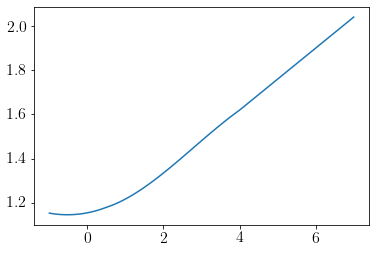

In [12]:
bprp = np.linspace(-1,7,100)
plt.plot(bprp, excess_correction(bprp))

In [13]:
for cardinal in ['north', 'south']:
    sample[cardinal]['phot_bp_rp_excess_factor_c'] = \
    sample[cardinal]['phot_bp_rp_excess_factor']-excess_correction(sample[cardinal]['bp_rp'])

## unWISE & SDSS

In [14]:
spec = {}
for key in sample['north'].keys():
    spec[key] = np.hstack((sample['north'][key], sample['south'][key]))
spec['north'] = np.hstack((np.ones(len(sample['north']['source_id']), dtype=bool), 
                           np.zeros(len(sample['south']['source_id']), dtype=bool)))
spec['south'] = ~spec['north']

In [9]:
# spec['w1'] = 22.5-2.5*np.log10(spec['flux_w1'])
# spec['w2'] = 22.5-2.5*np.log10(spec['flux_w2'])
# spec['phot_bp_rp_excess_factor_c'] = \
# spec['phot_bp_rp_excess_factor']-excess_correction(spec['phot_bp_mean_mag']-spec['phot_rp_mean_mag'])

CPU times: user 18 s, sys: 3.8 s, total: 21.8 s
Wall time: 2min 14s


In [15]:
# ra_poles = ns_eq.ra.rad; dec_poles = ns_eq.dec.rad
# sep_poles = np.arccos(np.sin(dec_poles)*np.sin(np.deg2rad(spec['dec'][:,None])) \
#               + np.cos(dec_poles)*np.cos(np.deg2rad(spec['dec'][:,None]))*\
#                 np.cos(ra_poles-np.deg2rad(spec['ra'][:,None])))
# spec['north'] = sep_poles[:,0]*180/np.pi<=10.00001
# spec['south'] = sep_poles[:,1]*180/np.pi<=10.00001

In [15]:
print(np.sum(~np.isnan(spec['specobjid'])), len(spec['specobjid']))
print(np.sum(~np.isnan(spec['specobjid'])&~np.isnan(spec['parallax'])), np.sum(~np.isnan(spec['parallax'])))
print(np.sum(~np.isnan(spec['specobjid'])&spec['south']), len(spec['specobjid']))
print(np.unique(spec['class'][~np.isnan(spec['specobjid'])&~np.isnan(spec['parallax'])], return_counts=True))

52550 1847222
25246 1427732
293 1847222
(array([b'GALAXY', b'QSO', b'STAR'], dtype='|S20'), array([ 1861,  8469, 14916]))


In [16]:
excess_cut = 1.8
w1w2_cut=0.5
bprp_cut=1.2

galaxies = spec['phot_bp_rp_excess_factor_c']>excess_cut
# galaxies = spec['phot_bp_rp_excess_factor_c']>30*sigma_c(spec['phot_g_mean_mag'])

quasars  = (spec['w1']-spec['w2']>w1w2_cut)&(spec['bp_rp']<bprp_cut)
quasars  = (spec['w1']-spec['w2']>w1w2_cut)&((spec['bp_rp'])<(spec['w1']-spec['w2'])+0.7)
#quasars = (x-2)**2 + (y)**2 < 4
x = spec['w1']-spec['w2']
y = spec['bp_rp']

astrometry = spec['select1']#~np.isnan(spec['parallax'])

In [17]:
np.sum(galaxies&astrometry), np.sum(quasars&astrometry), np.sum(galaxies&quasars&astrometry)

(10640, 51371, 963)

In [18]:
np.sum(galaxies&astrometry&spec['north']), np.sum(quasars&astrometry&spec['north']), np.sum(galaxies&quasars&astrometry&spec['north'])

(5186, 25994, 466)

In [19]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)
plt.rc('font',size=24)

In [20]:
spec_all = spec['class'].astype('<U10')!='None'
spec_qso = spec['class'].astype('<U10')=='QSO'
spec_gal = spec['class'].astype('<U10')=='GALAXY'

In [21]:
print(f"Completeness Galaxies: {np.sum(galaxies&spec_gal&astrometry)/np.sum(spec_gal&astrometry):.3f}")
print(f"Completeness Quasars: {np.sum(quasars&spec_qso&astrometry)/np.sum(spec_qso&astrometry):.3f}")

print(f"Purity Galaxies: {np.sum(galaxies&spec_gal&astrometry)/np.sum(galaxies&spec_all&astrometry):.3f}")
print(f"Purity Quasars:  {np.sum(quasars&spec_qso&astrometry)/np.sum(quasars&spec_all&astrometry):.3f}")

print(f"Completeness All:  {np.sum((quasars|galaxies)&(spec_qso|spec_gal)&astrometry)/np.sum((spec_qso|spec_gal)&astrometry):.3f}")
print(f"Purity All:  {np.sum((quasars|galaxies)&(spec_qso|spec_gal)&astrometry)/np.sum((quasars|galaxies)&spec_all&astrometry):.3f}")

Completeness Galaxies: 0.839
Completeness Quasars: 0.922
Purity Galaxies: 0.902
Purity Quasars:  0.962
Completeness All:  0.921
Purity All:  0.985


In [22]:
subset = spec['select1']&spec['select2']
print(f"Completeness Galaxies: {np.sum(galaxies&spec_gal&subset)/np.sum(spec_gal&subset):.3f}")
print(f"Completeness Quasars: {np.sum(quasars&spec_qso&subset)/np.sum(spec_qso&subset):.3f}")

print(f"Purity Galaxies: {np.sum(galaxies&spec_gal&subset)/np.sum(galaxies&spec_all&subset):.3f}")
print(f"Purity Quasars:  {np.sum(quasars&spec_qso&subset)/np.sum(quasars&spec_all&subset):.3f}")

print(f"Completeness All:  {np.sum((quasars|galaxies)&(spec_qso|spec_gal)&subset)/np.sum((spec_qso|spec_gal)&subset):.3f}")
print(f"Purity All:  {np.sum((quasars|galaxies)&(spec_qso|spec_gal)&subset)/np.sum((quasars|galaxies)&spec_all&subset):.3f}")

Completeness Galaxies: 0.454
Completeness Quasars: 0.925
Purity Galaxies: 0.628
Purity Quasars:  0.971
Completeness All:  0.912
Purity All:  0.983


In [23]:
subset = spec['select1']&spec['select2']
np.sum(subset&(galaxies)),\
np.sum(subset&(quasars)),\
np.sum(subset&(galaxies&quasars))

(2933, 50726, 553)

In [24]:
subset = spec['select1']&spec['select2']
np.sum(subset&~np.isnan(spec['specobjid'])&(spec_gal|spec_qso)), \
np.sum(subset&~np.isnan(spec['specobjid'])&(galaxies|quasars)) ,\
np.sum(subset&~np.isnan(spec['specobjid'])&(spec_gal|spec_qso)&(galaxies|quasars))

(8900, 8257, 8114)

In [25]:
np.sum(subset&~np.isnan(spec['specobjid'])&(galaxies)),\
np.sum(subset&~np.isnan(spec['specobjid'])&(quasars)),\
np.sum(subset&~np.isnan(spec['specobjid'])&(galaxies&quasars))

(349, 8024, 116)

In [100]:
subset.shape, galaxies.shape

((1847222,), (942006,))

In [126]:
np.sum(astrometry&~np.isnan(spec['w1'])), np.sum(astrometry)

(1259869, 1427315)

In [127]:
spec['class']

array([b'None', b'None', b'None', ..., b'None', b'None', b'None'],
      dtype='|S20')

In [128]:
np.sum(astrometry&~np.isnan(spec['specobjid'])), np.sum(astrometry)

(25244, 1427315)

In [129]:
np.sum(astrometry&~np.isnan(spec['specobjid'])&spec['north']), \
np.sum(astrometry&~np.isnan(spec['specobjid'])&spec['south'])

(24957, 287)

In [130]:
np.sum(astrometry&~np.isnan(spec['specobjid'])&(spec_gal|spec_qso)), \
np.sum(astrometry&~np.isnan(spec['specobjid'])&(spec_gal|spec_qso)&(galaxies|quasars))

(10330, 9513)

In [131]:
np.sum(astrometry&~np.isnan(spec['specobjid'])&(galaxies|quasars)), \
np.sum(astrometry&~np.isnan(spec['specobjid'])&(spec_gal|spec_qso)&(galaxies|quasars))

(9657, 9513)

In [132]:
np.sum(astrometry&~np.isnan(spec['specobjid'])&~(galaxies|quasars)&(spec_gal|spec_qso))

817

In [133]:
np.sum(astrometry&~np.isnan(spec['specobjid'])&~(galaxies|quasars)&(spec_gal|spec_qso))/\
np.sum(astrometry&~np.isnan(spec['specobjid'])&(spec_gal|spec_qso)) \
* np.sum(astrometry&(galaxies|quasars))/np.sum(astrometry)

0.0033827768172640265

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

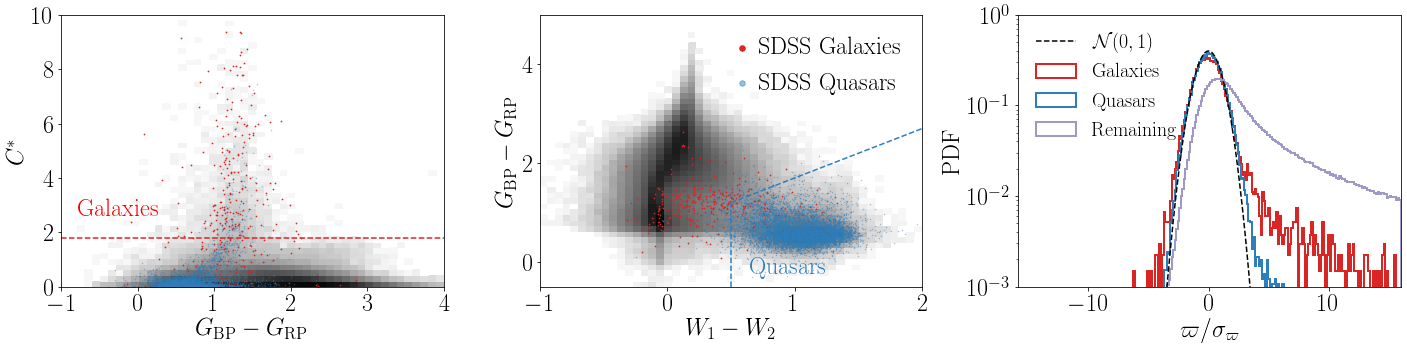

In [26]:
fig, axes = plt.subplots(1,3,figsize=(24,5))

subset = spec['select1']&spec['select2']#~np.isnan(spec['parallax']) #spec['south'] & 

c_gal = cm.Reds(0.7)
c_qso = cm.Blues(0.7)
c_other = cm.Purples(0.5)

plt.sca(axes[0])

lims = [-1,4,0,10]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(spec['bp_rp'][subset], 
                                       spec['phot_bp_rp_excess_factor_c'][subset],
                                       spec['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic
plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.ylabel(r'$C^*$')

plt.plot([lims[0],lims[1]], [excess_cut,excess_cut], linestyle='--', color=c_gal)

plt.text(lims[1]*0.15+lims[0]*0.85, excess_cut + lims[3]*0.1+lims[2]*0.9, "Galaxies", c='r', ha='center', va='center')

plt.xlim(lims[0], lims[1])
plt.ylim(lims[2], lims[3])


plt.scatter((spec['bp_rp'])[subset&spec_gal],
            spec['phot_bp_rp_excess_factor_c'][subset&spec_gal],
            s=0.5, alpha=1, c=c_gal, label='SDSS Galaxies')
plt.scatter((spec['bp_rp'])[subset&spec_qso],
            spec['phot_bp_rp_excess_factor_c'][subset&spec_qso],
            s=0.2, alpha=0.5, c=c_qso, label='SDSS Quasars')

plt.sca(axes[1])

lims = [-1,2,-0.5,5]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(spec['w1'][subset]-spec['w2'][subset],
                                       spec['bp_rp'][subset], 
                                       spec['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.ylabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.xlabel(r'$W_1 - W_2$')

w12cut = [w1w2_cut,lims[1]]
plt.plot([w12cut[0],w12cut[0]], [lims[2],bprp_cut], linestyle='--', color=c_qso)
bprpcut = [lims[2],bprp_cut]
#plt.plot(w12cut, [bprpcut[1],bprpcut[1]], linestyle='--', color=c_qso)
plt.plot([w1w2_cut,lims[1]],[w1w2_cut+0.7,lims[1]+0.7], linestyle='--', color=c_qso)


plt.scatter((spec['w1']-spec['w2'])[subset&spec_gal], 
            (spec['bp_rp'])[subset&spec_gal],
            s=0.5, alpha=1, c=c_gal, label='SDSS Galaxies')
plt.scatter((spec['w1']-spec['w2'])[subset&spec_qso], 
            (spec['bp_rp'])[subset&spec_qso],
            s=0.2, alpha=0.5, c=c_qso, label='SDSS Quasars')
lgnd = plt.legend(loc='upper right', frameon=False, handletextpad=-0.3)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

plt.xlim(lims[0], lims[1])
plt.ylim(lims[2], lims[3])

plt.text(w12cut[0]*0.7+lims[1]*0.3, 
         lims[2]*0.85+w12cut[1]*0.15, "Quasars", c=c_qso, ha='center', va='center')


plt.sca(axes[2])

bins = np.linspace(-16,16,251)

plt.hist((spec['parallax']/spec['parallax_error'])[galaxies], 
             bins=bins, label='Galaxies', histtype='step', density=True, linewidth=2, color=c_gal);
plt.hist((spec['parallax']/spec['parallax_error'])[quasars], 
             bins=bins, label='Quasars', histtype='step', density=True, linewidth=2, color=c_qso);
plt.hist((spec['parallax']/spec['parallax_error'])[~(galaxies|quasars)], 
             bins=bins, label='Remaining', histtype='step', density=True, linewidth=2, color=c_other);
plt.yscale('log'); plt.ylim(0.001,1.)

plt.plot(bins, scipy.stats.norm.pdf(bins,0,1), '--k', label=r"$\mathcal{N}(0,1)$")

plt.legend(loc='upper left', fontsize=20, frameon=False)
plt.xlim(bins[1], bins[-1])

plt.xlabel(r'$\varpi/\sigma_\varpi$'); plt.ylabel(r'PDF')

plt.subplots_adjust(wspace=0.25)

# plt.savefig('figs/extragalactic_unwise_sdss_source_filters.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

In [27]:
for cardinal in ['north', 'south']:
    galaxies = sample[cardinal]['phot_bp_rp_excess_factor_c']>excess_cut
    quasars  = (sample[cardinal]['w1']-sample[cardinal]['w2']>w1w2_cut)&(sample[cardinal]['bp_rp']<bprp_cut)
    quasars  = (sample[cardinal]['w1']-sample[cardinal]['w2']>w1w2_cut)&((sample[cardinal]['bp_rp'])<(sample[cardinal]['w1']-sample[cardinal]['w2'])+0.7)
    
    sample[cardinal]['select3'] = ~galaxies & ~quasars
    print(f"{cardinal} extragalactic: {np.sum(~sample[cardinal]['select3'])}")
    print(f"{cardinal} extragalactic and G/parallax: {np.sum(~sample[cardinal]['select3']&sample[cardinal]['select1'])}")
    print(f"{cardinal} extragalactic and G/parallax: {np.sum(~sample[cardinal]['select3']&sample[cardinal]['select2']&sample[cardinal]['select1'])}")

north extragalactic: 153021
north extragalactic and G/parallax: 30714
north extragalactic and G/parallax: 26845
south extragalactic: 153472
south extragalactic and G/parallax: 30334
south extragalactic and G/parallax: 26261


north extragalactic: 153021
north extragalactic and no G/parallax: 122307
south extragalactic: 153472
south extragalactic and no G/parallax: 123138


north extragalactic: 153025
north extragalactic and no G/parallax: 122307
south extragalactic: 153472
south extragalactic and no G/parallax: 123138


# 3) Mask

In [51]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [29]:
ns_eq = SkyCoord(l=[0,0],b=[90,-90], unit='deg',frame='galactic').icrs
ns_eq

<SkyCoord (ICRS): (ra, dec) in deg
    [(192.85947789,  27.12825241), ( 12.85947789, -27.12825241)]>

In [30]:
substruct={}

### Sculptor

In [31]:
sculptor = SkyCoord(ra="1h00m09.4s", dec="−33° 42′ 33″", frame='icrs')
#01h00m09.s4 −33d42m33s
# sculptor = SkyCoord(ra="00h 57.7m", dec="−33° 59′", frame='icrs')
substruct['SclD'] = [sculptor.ra.deg, sculptor.dec.deg, 11.3]#6.8]#5.8]#76.5

In [32]:
sculptor.galactic

<SkyCoord (Galactic): (l, b) in deg
    (287.53406044, -83.15649909)>

### NGC 288

In [33]:
df = pd.read_csv('/data/asfe2/Projects/mwtrace_data/vasiliev_gc.tsv', delimiter=';', skiprows=58)[2:]

GCs = SkyCoord(ra=df['RAJ2000'], dec=df['DEJ2000'], unit='deg', frame='icrs')
GCs_gal = GCs.transform_to('galactic')
l_gc, b_gc = GCs_gal.l.deg, GCs_gal.b.deg

df.set_index('Name', inplace=True)
df.loc['NGC 288    ']

OName                   
RAJ2000          013.188
DEJ2000          -26.583
Dist                 8.9
HRV               -44.83
e_HRV               0.13
pmRA               4.252
pmDE              -5.641
e_pmRA             0.053
e_pmDE             0.052
corr               0.019
Rscale               6.1
Nstar               2544
SimbadName       NGC 288
Name: NGC 288    , dtype: object

In [34]:
substruct['NGC288'] = [float(df.loc['NGC 288    '][key]) for key in ['RAJ2000','DEJ2000','Rscale']]

In [35]:
substruct

{'SclD': [15.039166666666665, -33.70916666666667, 11.3],
 'NGC288': [13.188, -26.583, 6.1]}

In [36]:
masks = np.array([[15.0392, -33.7092, 11.3],
                  [13.188,  -26.583,  6.1]])

### Mask

In [37]:
# HEALPix at high res
nside_highres=1024
level=6
bmin = 80; _nside=2**level

pixarea = hp.nside2pixarea(2**level, degrees=True)

rapix, decpix = hp.pix2ang(nside_highres, np.arange(hp.nside2npix(nside_highres)), lonlat=True, nest=True)

ra_poles = ns_eq.ra.rad; dec_poles = ns_eq.dec.rad
sep_poles = np.arccos(np.sin(dec_poles)*np.sin(np.deg2rad(decpix[:,None])) \
              + np.cos(dec_poles)*np.cos(np.deg2rad(decpix[:,None]))*\
                np.cos(ra_poles-np.deg2rad(rapix[:,None])))
pixweight = np.sum(np.reshape(np.sum(np.rad2deg(sep_poles)<10, axis=1), (-1, int ( nside_highres/_nside )**2)), axis=1)/ int ( nside_highres/_nside )**2    

In [38]:
for cardinal in ['north', 'south']:
    coords = SkyCoord(l=sample[cardinal]['l'], b=sample[cardinal]['b'], unit='deg', frame='galactic').icrs
    ra_source, dec_source = coords.ra.rad, coords.dec.rad

#     ra_sub =  np.array([substruct[key][0] for key in substruct.keys()])
#     dec_sub = np.array([substruct[key][1] for key in substruct.keys()])
#     rad_sub = np.array([substruct[key][2] for key in substruct.keys()])
    ra_sub, dec_sub, rad_sub = masks.T
    minsep_rad = 4 * rad_sub*np.pi/180/60

    source_sub = np.arccos(np.sin(dec_source)*np.sin(np.deg2rad(dec_sub[:,None])) \
                  + np.cos(dec_source)*np.cos(np.deg2rad(dec_sub[:,None]))*\
                    np.cos(ra_source-np.deg2rad(ra_sub[:,None])))
    
    sample[cardinal]['select4'] = np.prod(source_sub.T > minsep_rad, axis=1).astype(bool)

In [39]:
sep_sub = np.arccos(np.sin(np.deg2rad(dec_sub))*np.sin(np.deg2rad(decpix[:,None])) \
              + np.cos(np.deg2rad(dec_sub))*np.cos(np.deg2rad(decpix[:,None]))*\
                np.cos(np.deg2rad(ra_sub)-np.deg2rad(rapix[:,None])))
pixweight_sub = np.sum(np.reshape(np.sum(np.rad2deg(sep_poles)<10, axis=1) * np.prod(sep_sub > minsep_rad, axis=1).astype(bool), (-1, int ( nside_highres/_nside )**2)), axis=1)/ int ( nside_highres/_nside )**2    
#pixweight_sub = np.sum(np.reshape(np.prod(sep_sub.T > minsep_rad, axis=1).astype(bool), (-1, int ( nside_highres/_nside )**2)), axis=1)/ int ( nside_highres/_nside )**2    

In [40]:
hist = {}; hist_full={}
for i, cardinal in enumerate(['north','south']):
    sample[cardinal]['hpx'] = sample[cardinal]['source_id']//(2**35 * 4**(12-level))
    
    subset = sample[cardinal]['select1']&sample[cardinal]['select2']&sample[cardinal]['select3']&sample[cardinal]['select4']
    hpx, nhpx = np.unique(sample[cardinal]['hpx'][subset], return_counts=True)
    hist[cardinal] = np.zeros(hp.nside2npix(2**level), dtype='float')
    hist[cardinal][hpx] = nhpx/(pixarea*pixweight_sub[hpx])
    hist[cardinal][hist[cardinal]==0] = np.nan
    
    subset = sample[cardinal]['select1']&sample[cardinal]['select2']&sample[cardinal]['select3']
    hpx, nhpx = np.unique(sample[cardinal]['hpx'][subset], return_counts=True)
    hist_full[cardinal] = np.zeros(hp.nside2npix(2**level), dtype='float')
    hist_full[cardinal][hpx] = nhpx/(pixarea*pixweight[hpx])
    hist_full[cardinal][hist_full[cardinal]==0] = np.nan
    
    print(np.nanmin(hist[cardinal]), np.nanmax(hist[cardinal][~np.isinf(hist[cardinal])]))

1525.0919714493384 2976.9795282691084
1592.873836847087 3965.2391257682802


In [54]:
from matplotlib.patches import Arrow, FancyArrow

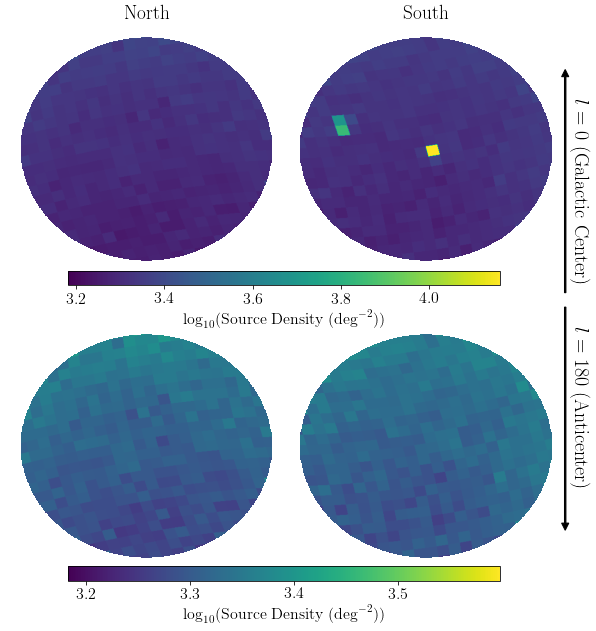

In [63]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

lat = {'north':90, 'south':-90}

#minmax = [500,50000]
minmax = [min(np.nanmin(hist['south']), np.nanmin(hist['north'])),
          max(np.nanmax(hist['south'][~np.isinf(hist['south'])]), np.nanmax(hist['north'][~np.isinf(hist['north'])]))]

minmax_full = [min(np.nanmin(hist_full['south']), np.nanmin(hist_full['north'])),
          max(np.nanmax(hist_full['south'][~np.isinf(hist_full['south'])]), np.nanmax(hist_full['north'][~np.isinf(hist_full['north'])]))]

res = 500
x = np.linspace(-11,11,res)
y = np.linspace(-11,11,res+10)
xx, yy = np.meshgrid(x,y)
l = np.rad2deg(np.arctan2(yy,xx))

clabels = {'north':'North', 'south':'South'}
for i, cardinal in enumerate(['north','south']):

    if cardinal=='north': b = 90 - np.sqrt(xx**2 + yy**2)
    else:  b = -90 + np.sqrt(xx**2 + yy**2)

    gal= SkyCoord(l, b, unit='deg', frame='galactic')
    eq = gal.transform_to('icrs')
    ra = eq.ra.deg; dec = eq.dec.deg

    hpx_pos = hp.ang2pix(2**level,ra,dec,nest=True, lonlat=True)
    
    plt.sca(axes[0,i])
    grid = hist_full[cardinal][hpx_pos]
    grid[np.abs(b)<80] = np.nan
    plt.imshow(grid.T[::-1], norm=LogNorm(), vmin=minmax_full[0], vmax=minmax_full[1], aspect='auto')
    plt.axis('off')
    plt.title(clabels[cardinal])
    
    plt.sca(axes[1,i])
    grid = hist[cardinal][hpx_pos]
    grid[np.abs(b)<80] = np.nan
    plt.imshow(grid.T[::-1], norm=LogNorm(), vmin=minmax[0], vmax=minmax[1], aspect='auto')
    plt.axis('off')
    
    
ax = fig.add_axes([0.21, 0.52, 0.6, 0.02]); 
ticks = np.arange(0,np.log10(minmax_full[1])+0.5,0.2)
cbar = add_log_cbar(ax, vmin=minmax_full[0], vmax=minmax_full[1], orientation='horizontal',
            ticks=10**ticks, tick_labels=[fr'${power:.1f}$' for power in ticks])
cbar.set_label(r'$\log_{10}($Source Density $(\mathrm{deg}^{-2}))$')
    
ax = fig.add_axes([0.21, 0.11, 0.6, 0.02]); 
ticks = np.arange(0,np.log10(minmax[1])+0.5, 0.1)
cbar = add_log_cbar(ax, vmin=minmax[0], vmax=minmax[1], orientation='horizontal',
            ticks=10**ticks, tick_labels=[fr'${power:.1f}$' for power in ticks])# tick_labels=[fr'${10**power:.0f}$' for power in ticks])
cbar.set_label(r'$\log_{10}($Source Density $(\mathrm{deg}^{-2}))$')
    
arrow_kwargs = dict(fc='k', ec='k', width=0.002, head_length=0.01, head_width=0.01)
arrow_bright = FancyArrow(0.9, 0.51, 0., 0.3, **arrow_kwargs); fig.add_artist(arrow_bright)
fig.text(.92, 0.65,r'$l=0$ (Galactic Center)',ha='center', va='center', rotation=270, fontsize=20)
arrow_dim = FancyArrow(0.9, 0.49, 0., -0.3, **arrow_kwargs); fig.add_artist(arrow_dim)
fig.text(.92, 0.35,r'$l=180$ (Anticenter)',ha='center', va='center', rotation=270, fontsize=20)
    
plt.subplots_adjust(wspace=0.)

plt.savefig('figs/source_density.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# 3) Absolute magnitude

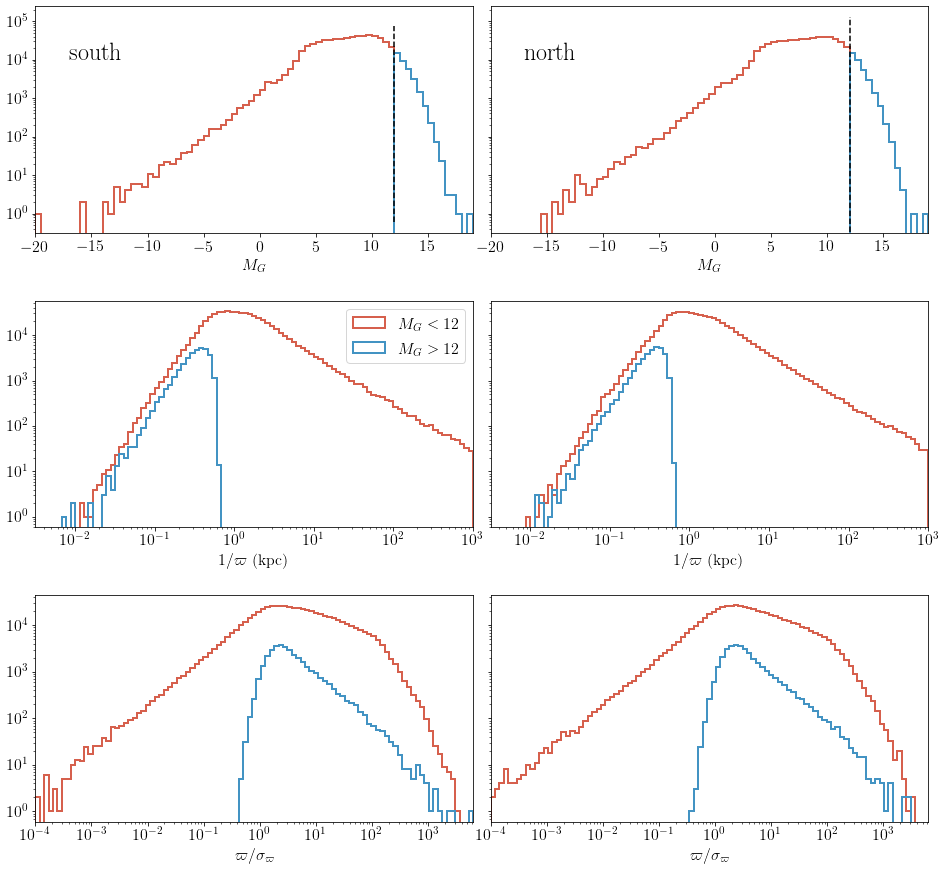

In [149]:
fig, axes = plt.subplots(3,2,figsize=(16,15), sharey='row')

colours = [cm.RdBu(0.8), cm.RdBu(0.2)]
hist_keys = [{'color':cm.RdBu(0.2), 'linewidth':2, 'histtype':'step'},
             {'color':cm.RdBu(0.8), 'linewidth':2, 'histtype':'step'}]

for i, cardinal in enumerate(['south', 'north']):
    
    xlim = (-20.,19.)
    plt.sca(axes[0,i])
    plt.hist(sample[cardinal]['M'][sample[cardinal]['M']<12], 
             bins=np.linspace(*xlim, 79), **hist_keys[0]);
    plt.hist(sample[cardinal]['M'][sample[cardinal]['M']>12], 
             bins=np.linspace(*xlim, 79), **hist_keys[1]);
    plt.xlim(xlim); plt.yscale('log'); plt.xlabel(r'$M_G$')
    plt.text(-17, 1e4, cardinal, fontsize=24)
    
    plt.sca(axes[1,i])
    xlim = (-2.5,3)
    plt.hist(1/sample[cardinal]['parallax_obs'][sample[cardinal]['M']<12], 
             bins=np.logspace(*xlim,100), **hist_keys[0], label=r'$M_G < 12$');
    plt.hist(1/sample[cardinal]['parallax_obs'][sample[cardinal]['M']>12], 
             bins=np.logspace(*xlim,100), **hist_keys[1], label=r'$M_G > 12$');
    # plt.hist(1/sample[cardinal]['parallax_obs'][sample[cardinal]['M']<=12], bins=np.logspace(*xlim,100), color='g', histtype='step', linewidth=2);
    if i==0: plt.legend(loc='upper right')
    plt.xlim(10**xlim[0], 10**xlim[1])
    plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$1/\varpi$ (kpc)')
    
    plt.sca(axes[2,i])
    xlim = (-4,3.8)
    plt.hist((sample[cardinal]['parallax_obs']/sample[cardinal]['parallax_error'])[sample[cardinal]['M']<12], 
             bins=np.logspace(*xlim,100), **hist_keys[0]);
    plt.hist((sample[cardinal]['parallax_obs']/sample[cardinal]['parallax_error'])[sample[cardinal]['M']>12], 
             bins=np.logspace(*xlim,100), **hist_keys[1]);
    plt.xlim(10**xlim[0], 10**xlim[1])
    plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$\varpi/\sigma_\varpi$')
    
for i in range(2): plt.sca(axes[0,i]); plt.plot([12,12], axes[0,1].get_ylim(), '--k')
    
plt.subplots_adjust(wspace=0.04, hspace=0.3)

# plt.savefig(f'figs/M12_cut_histograms.png', bbox_inches='tight', dpi=200)

In [42]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)
plt.rc('font',size=24)

13731/653803, 2.10%
13792/647081, 2.13%


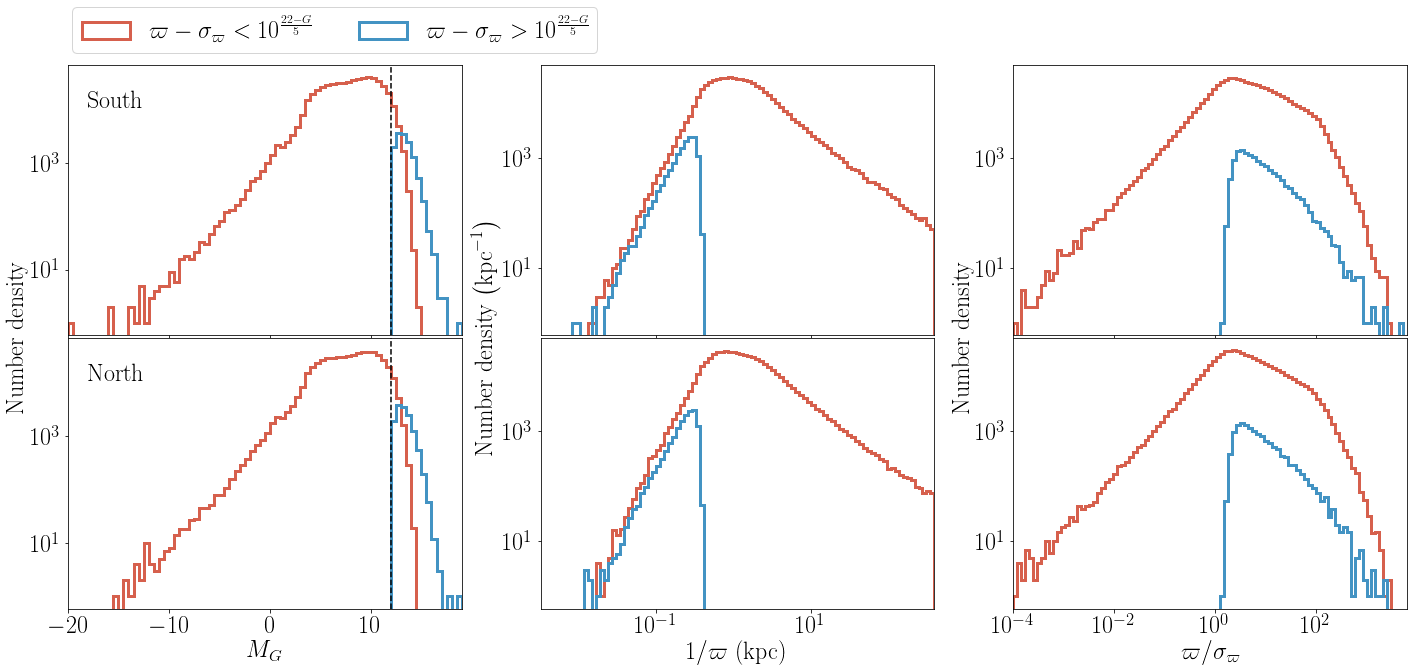

In [49]:
fig, axes = plt.subplots(2,3,figsize=(24,10), sharex='col', sharey='col')

colours = [cm.RdBu(0.8), cm.RdBu(0.2)]
hist_keys = [{'color':cm.RdBu(0.2), 'linewidth':3, 'histtype':'step'},
             {'color':cm.RdBu(0.8), 'linewidth':3, 'histtype':'step'}]

cardinals = ['south', 'north']
for i, cardinal in enumerate(cardinals):
    
#     select = ~((sample[cardinal]['M']>12)&\
#                (sample[cardinal]['parallax_obs']/sample[cardinal]['parallax_error_corr']>1))
    sub = sample[cardinal]['select1']&sample[cardinal]['select2']&sample[cardinal]['select3']&sample[cardinal]['select4']
    
    select = (sample[cardinal]['parallax_obs'][sub]-sample[cardinal]['parallax_error_corr'][sub] < \
              10**((22-sample[cardinal]['m'][sub])/5)) 
    print(f"{np.sum(~select)}/{len(select)}, {100*np.sum(~select)/len(select):.2f}%")
    
    xlim = (-20.,19.)
    plt.sca(axes[i,0])
    plt.hist(sample[cardinal]['M'][sub][select], 
             bins=np.linspace(*xlim, 79), **hist_keys[0], label=r'$\varpi-\sigma_\varpi < 10^{\frac{22-G}{5}}$');
    plt.hist(sample[cardinal]['M'][sub][~select], 
             bins=np.linspace(*xlim, 79), **hist_keys[1], label=r'$\varpi-\sigma_\varpi > 10^{\frac{22-G}{5}}$');
    if i==1: 
        plt.xlim(xlim); plt.yscale('log'); plt.xlabel(r'$M_G$'); 
    if i==0:
        plt.legend(loc='lower left', bbox_to_anchor=(-0.02,1.), ncol=2)
        
    # plt.text(-17, 1e4, cardinal, fontsize=24)
    
    plt.sca(axes[i,1])
    xlim = (-2.5,2.6)
    plt.hist(1/sample[cardinal]['parallax_obs'][sub][select], 
             bins=np.logspace(*xlim,100), **hist_keys[0], label=r'$\varpi-\sigma_\varpi < 10^{\frac{22-G}{5}}$');
    plt.hist(1/sample[cardinal]['parallax_obs'][sub][~select], 
             bins=np.logspace(*xlim,100), **hist_keys[1], label=r'$\varpi-\sigma_\varpi > 10^{\frac{22-G}{5}}$');
    # plt.hist(1/sample[cardinal]['parallax_obs'][sample[cardinal]['M']<=12], bins=np.logspace(*xlim,100), color='g', histtype='step', linewidth=2);
    # if i==0: plt.legend(loc='upper right')
    plt.xlim(10**xlim[0], 10**xlim[1])
    if i==1: plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$1/\varpi$ (kpc)')
    
    plt.sca(axes[i,2])
    xlim = (-4,3.8)
    plt.hist((sample[cardinal]['parallax_obs']/sample[cardinal]['parallax_error_corr'])[sub][select], 
             bins=np.logspace(*xlim,100), **hist_keys[0]);
    plt.hist((sample[cardinal]['parallax_obs']/sample[cardinal]['parallax_error_corr'])[sub][~select], 
             bins=np.logspace(*xlim,100), **hist_keys[1]);
    plt.xlim(10**xlim[0], 10**xlim[1])
    if i==1: plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$\varpi/\sigma_\varpi$')
    
plt.subplots_adjust(wspace=0.2, hspace=0.01)

plt.sca(axes[0,0])
plt.ylim(axes[0,0].get_ylim())
for i, cardinal in enumerate(cardinals): 
    plt.sca(axes[i,0])
    plt.plot([12,12], axes[0,0].get_ylim(), '--k')
    plt.text(axes[1,0].get_xlim()[0]*0.95 + axes[1,0].get_xlim()[1]*0.05,
             axes[1,0].get_ylim()[0]**0.1 * axes[1,0].get_ylim()[1]**0.9, clabels[cardinal],
            ha='left', va='top')

fig.add_subplot(131, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r'Number density')

fig.add_subplot(132, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r'Number density $\left(\mathrm{kpc}^{-1}\right)$')

fig.add_subplot(133, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r'Number density')
    
plt.savefig(f'figs/M12_cut_histograms.png', bbox_inches='tight', dpi=200)

In [78]:
for cardinal in ['north','south']:
    sample[cardinal]['select5'] = (sample[cardinal]['parallax_obs']-sample[cardinal]['parallax_error_corr'] < \
              10**((22-sample[cardinal]['m'])/5))
    sub = sample[cardinal]['select1']&sample[cardinal]['select2']&sample[cardinal]['select3']&sample[cardinal]['select4']

    print(f"""{cardinal}: {1/np.min(sample[cardinal]['parallax_obs'][~sample[cardinal]['select5']&sub])}""")
    print(f"""{cardinal}: {np.min(sample[cardinal]['parallax_obs'][~sample[cardinal]['select5']&sub]/sample[cardinal]['parallax_error'][~sample[cardinal]['select5']&sub])}""")

north: 0.3784216695905926
north: 1.4002156344825174
south: 0.39375223195254166
south: 1.4135650828158874


# Final sample

In [153]:
np.sum(galaxies&sample[cardinal]['select1']), np.sum(quasars&sample[cardinal]['select1'])

(5454, 25377)

In [87]:
for cardinal in ['north', 'south']:
    #sample[cardinal]['select5'] = (sample[cardinal]['phot_g_mean_mag']>5)&(sample[cardinal]['phot_g_mean_mag']<22)
    #sample[cardinal]['select6'] = (sample[cardinal]['ruwe']<1.4)
    print(cardinal)
    print(f"Full: {len(sample[cardinal]['source_id'])}")
    print(f"G&Parallax: {np.sum(sample[cardinal]['select1'])}")
    print(f"RUWE: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,3)], axis=0))}")
    print(f"Gal: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,4)], axis=0))}")
    print(f"Mask: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,5)], axis=0))}")
    print(f"M12: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,6)], axis=0))}")
#     print(f"G&P, Gal, Mask, M12, Grange: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,7)], axis=0))}")
#     print(f"G&P, Gal, Mask, M12, Grange, ruwe: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,7)], axis=0))}")

north
Full: 905216
G&Parallax: 697662
RUWE: 673926
Gal: 647081
Mask: 647081
M12: 633289
south
Full: 942006
G&Parallax: 729653
RUWE: 702599
Gal: 676338
Mask: 653803
M12: 640072


In [114]:
for cardinal in ['north', 'south']:
    #sample[cardinal]['select5'] = (sample[cardinal]['phot_g_mean_mag']>5)&(sample[cardinal]['phot_g_mean_mag']<22)
    #sample[cardinal]['select6'] = (sample[cardinal]['ruwe']<1.4)
    print(cardinal)
    print(f"Full: {len(sample[cardinal]['source_id'])}")
    print(f"G&Parallax: {np.sum(~sample[cardinal]['select1'])}")
    print(f"RUWE:{np.sum(sample[cardinal]['select1']&~sample[cardinal]['select2'])}")
    print(f"Gal: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,3)], axis=0)&~sample[cardinal]['select3'])}")
    print(f"Mask: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,4)], axis=0)&~sample[cardinal]['select4'])}")
    print(f"M12: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,5)], axis=0)&~sample[cardinal]['select5'])}")
#     print(f"G&P, Gal, Mask, M12, Grange: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,7)], axis=0))}")
#     print(f"G&P, Gal, Mask, M12, Grange, ruwe: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,7)], axis=0))}")

north
Full: 905216
G&Parallax: 207554
RUWE:23736
Gal: 26845
Mask: 0
M12: 13792
south
Full: 942006
G&Parallax: 212353
RUWE:27054
Gal: 26261
Mask: 22535
M12: 13731


In [90]:
np.sum([np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,6)], axis=0)) for cardinal in ['north','south']]),\
np.sum([np.sum(sample[cardinal][f'select1']) for cardinal in ['north','south']])

(1273361, 1427315)

In [91]:
np.sum([np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,6)], axis=0)) for cardinal in ['north','south']])/\
np.sum([np.sum(sample[cardinal][f'select1']) for cardinal in ['north','south']])

0.8921373347859443

In [93]:
np.sum([np.sum(sample[cardinal][f'select1']&(sample[cardinal][f'parallax']>0)) for cardinal in ['north','south']])/\
np.sum([np.sum(sample[cardinal][f'select1']) for cardinal in ['north','south']])

0.8466869611823599

In [94]:
np.sum([np.sum(sample[cardinal][f'select1']&(sample[cardinal][f'parallax']/sample[cardinal][f'parallax_error']>4)) for cardinal in ['north','south']])/\
np.sum([np.sum(sample[cardinal][f'select1']) for cardinal in ['north','south']])

0.38540196102472124

In [86]:
np.nanmax(sample['south']['phot_g_mean_mag'][~np.isnan(sample['south']['parallax'])]), \
np.nanmax(sample['north']['phot_g_mean_mag'][~np.isnan(sample['north']['parallax'])])

(21.433363, 21.333527)

In [49]:
for cardinal in ['north', 'south']:
    sample[cardinal]['select5'] = (sample[cardinal]['phot_g_mean_mag']>5)&(sample[cardinal]['phot_g_mean_mag']<22)
    print(cardinal)
    print(f"Full: {len(sample[cardinal]['source_id'])}")
    print(f"G&Parallax: {np.sum(~sample[cardinal]['select1'])}")
    print(f"Gal: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,2)], axis=0)&~sample[cardinal]['select2'])}")
    print(f"Mask: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,3)], axis=0)&~sample[cardinal]['select3'])}")
    print(f"M12: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,4)], axis=0)&~sample[cardinal]['select4'])}")
    print(f"Grange: {np.sum(np.prod([sample[cardinal][f'select{i}'] for i in range(1,5)], axis=0)&~sample[cardinal]['select5'])}")

north
Full: 905216
G&Parallax: 207554
Gal: 30718
Mask: 0
M12: 13823
Grange: 11
south
Full: 942006
G&Parallax: 212353
Gal: 30334
Mask: 23565
M12: 13754
Grange: 6


# Old code

# Position

In [1]:
# Load Sample
sample = {'north':{}, 'south':{}};
filename = f'/data/asfe2/Projects/mwtrace_data/gaia/{file}.h'
with h5py.File(filename, 'r') as hf:
    for cardinal in ['north', 'south']:
        subset = np.intersect1d(hf[cardinal]['source_id'][...], model[cardinal].sample['source_id'], return_indices=True)[1]
        for key in hf[cardinal].keys():
            sample[cardinal][key]=hf[cardinal][key][...][subset]

NameError: name 'file' is not defined

In [ ]:
for cardinal in ['north', 'south']:
    model[cardinal]._generate_fid_pars()
    model[cardinal].sample=sample

# Plot data

In [13]:
ns_eq = SkyCoord(l=[0,0],b=[90,-90], unit='deg',frame='galactic').icrs
ns_eq

<SkyCoord (ICRS): (ra, dec) in deg
    [(192.85947789,  27.12825241), ( 12.85947789, -27.12825241)]>

In [7]:
for cardinal in ['north','south']:
    sample[cardinal]['subset'] = (sample[cardinal]['parallax_obs']-sample[cardinal]['parallax_error'] \
                                          < 10**((22-sample[cardinal]['m'])/5)) \
                                 & (sample[cardinal]['m']>5) & (sample[cardinal]['m']<22)

### Satellite Galaxies

In [12]:
df = pd.read_csv('/data/asfe2/Projects/mwtrace_data/objsearch_div.csv', delimiter=',', skiprows=0)

sats = SkyCoord(ra=df[2:]['RA'], dec=df[2:]['DEC'], unit='deg', frame='icrs')
sats_gal = sats.transform_to('galactic')
l_sat, b_sat = sats_gal.l.deg, sats_gal.b.deg

# Reweight pixels

In [82]:
# HEALPix at high res
nside_highres=512
level=8
bmin = 80; _nside=2**level

pixarea = hp.nside2pixarea(2**level, degrees=True)

rapix, decpix = hp.pix2ang(nside_highres, np.arange(hp.nside2npix(nside_highres)), lonlat=True, nest=True)

if False:
    _eq=SkyCoord(ra=rapix, dec=decpix, unit='deg', frame='icrs')
    _gal=_eq.galactic; bpix_highres=np.abs(_gal.b.deg)
    pixweight = np.sum(np.reshape(bpix_highres>bmin, (-1, int ( nside_highres/_nside )**2)), axis=1)/ int ( nside_highres/_nside )**2    
if True:
    ra_poles = ns_eq.ra.rad; dec_poles = ns_eq.dec.rad
    sep = np.arccos(np.sin(dec_poles)*np.sin(np.deg2rad(decpix[:,None])) \
                  + np.cos(dec_poles)*np.cos(np.deg2rad(decpix[:,None]))*\
                    np.cos(ra_poles-np.deg2rad(rapix[:,None])))
    pixweight = np.sum(np.reshape(np.sum(np.rad2deg(sep)<10, axis=1), (-1, int ( nside_highres/_nside )**2)), axis=1)/ int ( nside_highres/_nside )**2    

In [83]:
hist = {}
for i, cardinal in enumerate(['North','South']):
    hpx = sample[cardinal.lower()]['source_id']//(2**35 * 4**(12-level))
    hpx, nhpx = np.unique(hpx[sample[cardinal.lower()]['subset']], return_counts=True)
    hist[cardinal.lower()] = np.zeros(hp.nside2npix(2**level), dtype='float')
    hist[cardinal.lower()][hpx] = nhpx/(pixarea*pixweight[hpx])
    hist[cardinal.lower()][hist[cardinal.lower()]==0] = np.nan
    
    print(np.nanmin(hist[cardinal.lower()]), np.nanmax(hist[cardinal.lower()][~np.isinf(hist[cardinal.lower()])]))

838.8005842971362 4499.021315775549
838.8005842971362 211568.38373930947


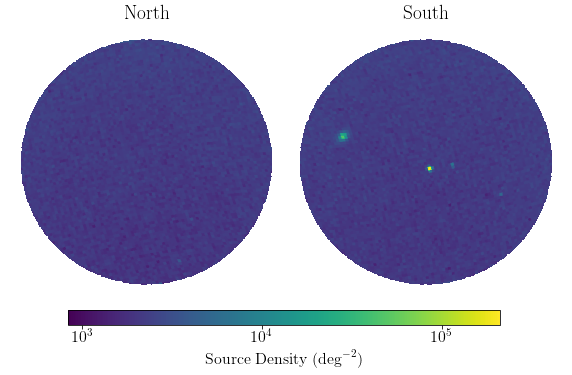

In [84]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

lat = {'north':90, 'south':-90}

#minmax = [500,50000]
minmax = [min(np.nanmin(hist['south']), np.nanmin(hist['north'])),
          max(np.nanmax(hist['south'][~np.isinf(hist['south'])]), np.nanmax(hist['north'][~np.isinf(hist['north'])]))]

for i, cardinal in enumerate(['North','South']):
    
    plt.sca(axes[i])
    
    res = 500
    x = np.linspace(-11,11,res)
    y = np.linspace(-11,11,res+10)
    xx, yy = np.meshgrid(x,y)

    if cardinal.lower()=='north': b = 90 - np.sqrt(xx**2 + yy**2)
    else:  b = -90 + np.sqrt(xx**2 + yy**2)
    l = np.rad2deg(np.arctan2(yy,xx))

    gal= SkyCoord(l, b, unit='deg', frame='galactic')
    eq = gal.transform_to('icrs')
    ra = eq.ra.deg; dec = eq.dec.deg

    hpx_pos = hp.ang2pix(2**level,ra,dec,nest=True, lonlat=True)
    grid = hist[cardinal.lower()][hpx_pos]
    
    grid[np.abs(b)<80] = np.nan
    
    plt.imshow(grid.T[::-1], norm=LogNorm(), vmin=minmax[0], vmax=minmax[1], aspect='auto')
    plt.axis('off')
    
    plt.title(cardinal)
    
    
ax = fig.add_axes([0.21, 0.05, 0.6, 0.04]); 
ticks = np.arange(np.log10(minmax[1])+0.1)
cbar = add_log_cbar(ax, vmin=minmax[0], vmax=minmax[1], orientation='horizontal',
            ticks=10**ticks, tick_labels=[fr'$10^{{{power:.0f}}}$' for power in ticks])
cbar.set_label(r'Source Density $(\mathrm{deg}^{-2})$')
    
plt.subplots_adjust(wspace=0.)

# plt.savefig('figs/source_density.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

In [289]:
substructure = np.argwhere((hist['south']>2e4)&(~np.isinf(hist['south'])))[:,0]
substructure, hist['south'][substructure]

(array([266357, 568797, 571528]),
 array([211568.38373931,  23143.27066674,  47277.85111493]))

In [290]:
arr = np.zeros(hp.nside2npix(2**level))+0.5
arr[substructure] = 1

In [284]:
arr = hist['south'].copy()
arr[arr<5e3]=0.
arr[arr>5e3]=1.

(-0.5, 499.5, 499.5, -0.5)

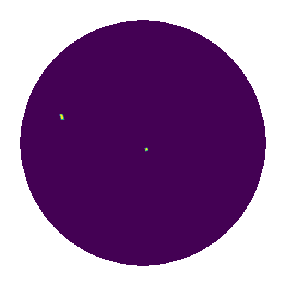

In [291]:
fig, axes = plt.subplots(1,1,figsize=(5,5))

pixarea = hp.nside2pixarea(2**level, degrees=True)

res = 500
x = np.linspace(-11,11,res)
y = np.linspace(-11,11,res)
xx, yy = np.meshgrid(x,y)

b = -90 + np.sqrt(xx**2 + yy**2)
l = np.rad2deg(np.arctan2(yy,xx))

gal= SkyCoord(l, b, unit='deg', frame='galactic')
eq = gal.transform_to('icrs')
ra = eq.ra.deg; dec = eq.dec.deg

hpx_pos = hp.ang2pix(2**level,ra,dec,nest=True, lonlat=True)
grid = arr[hpx_pos].copy()

grid[np.abs(b)<80] = np.nan

plt.imshow(grid.T[::-1])
plt.axis('off')

In [300]:
hp.max_pixrad(2**8, degrees=True)*60

14.34420720055738

In [301]:
# HEALPix at high res
bmin = 80; _nside=2**level

rapix, decpix = hp.pix2ang(_nside, np.arange(hp.nside2npix(_nside)), lonlat=True, nest=True)
np.vstack((rapix[substructure], decpix[substructure])).T

array([[ 13.18359375, -26.61009781],
       [ 14.94140625, -33.8687046 ],
       [ 15.1171875 , -33.68919326]])

In [ ]:
015.1074169	-33.5070592

In [293]:
_eq=SkyCoord(ra=rapix[substructure], dec=decpix[substructure], unit='deg', frame='icrs')
_eq.galactic

<SkyCoord (Galactic): (l, b) in deg
    [(152.16635373, -89.40663994), (288.54836974, -83.02547321),
     (286.96410233, -83.15684939)]>

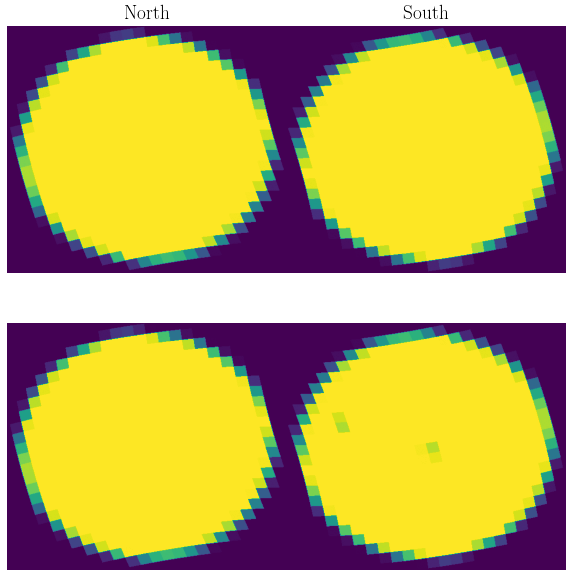

In [424]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

lat = {'north':90, 'south':-90}

#minmax = [500,50000]
minmax = [min(np.nanmin(hist['south']), np.nanmin(hist['north'])),
          max(np.nanmax(hist['south'][~np.isinf(hist['south'])]), np.nanmax(hist['north'][~np.isinf(hist['north'])]))]

minmax_full = [min(np.nanmin(hist_full['south']), np.nanmin(hist_full['north'])),
          max(np.nanmax(hist_full['south'][~np.isinf(hist_full['south'])]), np.nanmax(hist_full['north'][~np.isinf(hist_full['north'])]))]

res = 500
x = np.linspace(-11,11,res)
y = np.linspace(-11,11,res+10)
xx, yy = np.meshgrid(x,y)
l = np.rad2deg(np.arctan2(yy,xx))

for i, cardinal in enumerate(['North','South']):

    if cardinal.lower()=='north': b = 90 - np.sqrt(xx**2 + yy**2)
    else:  b = -90 + np.sqrt(xx**2 + yy**2)

    gal= SkyCoord(l, b, unit='deg', frame='galactic')
    eq = gal.transform_to('icrs')
    ra = eq.ra.deg; dec = eq.dec.deg

    hpx_pos = hp.ang2pix(2**level,ra,dec,nest=True, lonlat=True)
    
    plt.sca(axes[0,i])
    grid = pixweight[hpx_pos]
    plt.imshow(grid.T[::-1], vmin=0, vmax=1, aspect='auto')
    plt.axis('off')
    plt.title(cardinal)
    
    plt.sca(axes[1,i])
    grid = pixweight_sub[hpx_pos]
    plt.imshow(grid.T[::-1], vmin=0, vmax=1, aspect='auto')
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.)

# plt.savefig('figs/source_density.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Extragalactic sample

In [42]:
query = """select * from andy_everall.gaia_wise_b80"""

%time data = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 12.2 s, sys: 2.81 s, total: 15 s
Wall time: 1min 27s


In [8]:
query = """select * from andy_everall.gaia_unwise_b80"""

%time undata = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

undata['w1'] = 22.5-2.5*np.log10(undata['flux_w1'])
undata['w2'] = 22.5-2.5*np.log10(undata['flux_w2'])

CPU times: user 12.9 s, sys: 2.63 s, total: 15.5 s
Wall time: 1min 40s


In [8]:
query = """select gw.*, g3.* from andy_everall.gaia_wise_b80 as gw
            left join lateral(select phot_bp_rp_excess_factor from gaia_edr3.gaia_source as g3
                                    where g3.source_id=gw.source_id) as g3 on True"""

%time data = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 13.6 s, sys: 3.3 s, total: 16.9 s
Wall time: 1min 55s


In [11]:
data['phot_bp_rp_excess_factor_c'] = \
data['phot_bp_rp_excess_factor']-excess_correction(data['phot_bp_mean_mag']-data['phot_rp_mean_mag'])

### Colour-colour cuts

Text(0.5, 0, '$W_1 - W_2$')

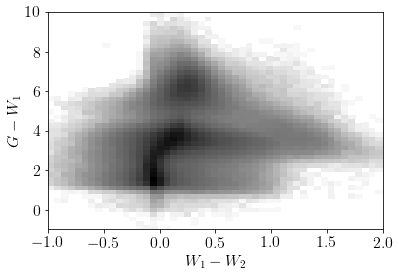

In [52]:
lims = [-1,2,-1,10]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(data['w1mpro']-data['w2mpro'],
                                       data['phot_g_mean_mag']-data['w1mpro'], 
                                       data['w1mpro']-data['w2mpro'],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.ylabel(r'$G-W_1$')
plt.xlabel(r'$W_1 - W_2$')

In [31]:
ra_poles = ns_eq.ra.rad; dec_poles = ns_eq.dec.rad
sep_poles = np.arccos(np.sin(dec_poles)*np.sin(np.deg2rad(data['dec'][:,None])) \
              + np.cos(dec_poles)*np.cos(np.deg2rad(data['dec'][:,None]))*\
                np.cos(ra_poles-np.deg2rad(data['ra'][:,None])))
data['north'] = sep_poles[:,0]*180/np.pi<=10.00001
data['south'] = sep_poles[:,1]*180/np.pi<=10.00001

Text(0.5, 0, '$W_1 - W_2$')

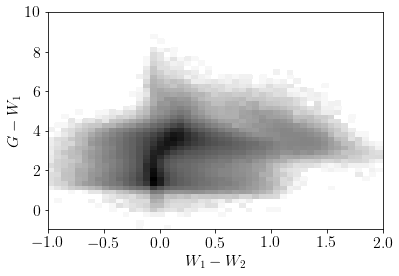

In [92]:
subset = data['north'] & ~np.isnan(data['parallax'])

lims = [-1,2,-1,10]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(data['w1mpro'][subset]-data['w2mpro'][subset],
                                       data['phot_g_mean_mag'][subset]-data['w1mpro'][subset], 
                                       data['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.ylabel(r'$G-W_1$')
plt.xlabel(r'$W_1 - W_2$')

[]

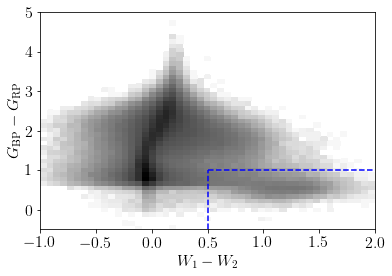

In [104]:
subset = data['north'] & ~np.isnan(data['parallax'])

lims = [-1,2,-0.5,5]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(data['w1mpro'][subset]-data['w2mpro'][subset],
                                       data['phot_bp_mean_mag'][subset]-data['phot_rp_mean_mag'][subset], 
                                       data['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.ylabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.xlabel(r'$W_1 - W_2$')

w12cut = [0.5,lims[1]]
bprpcut = [lims[2],1]
plt.plot(w12cut, [bprpcut[1],bprpcut[1]], '--b')
plt.plot([w12cut[0],w12cut[0]], bprpcut, '--b')

plt.plot()

### BP-RP excess factor cuts

Text(0, 0.5, '\\textsc{phot\\_bp\\_rp\\_excess\\_factor}')

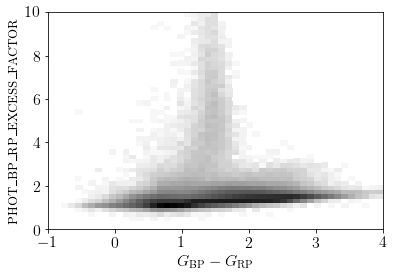

In [107]:
subset = data['south'] & ~np.isnan(data['parallax'])

lims = [-1,4,0,10]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(data['phot_bp_mean_mag'][subset]-data['phot_rp_mean_mag'][subset], 
                                       data['phot_bp_rp_excess_factor'][subset],
                                       data['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.ylabel(r'\textsc{phot\_bp\_rp\_excess\_factor}')

Text(0, 0.5, '$C^*$')

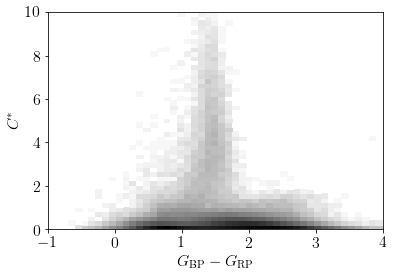

In [166]:
subset = data['south'] & ~np.isnan(data['parallax'])

lims = [-1,4,0,10]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(data['phot_bp_mean_mag'][subset]-data['phot_rp_mean_mag'][subset], 
                                       data['phot_bp_rp_excess_factor_c'][subset],
                                       data['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.ylabel(r'$C^*$')

### Sample selection

In [136]:
excess_cut = 1.5
w1w2_cut=0.5
bprp_cut=1.2

galaxies = data['phot_bp_rp_excess_factor_c']>excess_cut
# galaxies = data['phot_bp_rp_excess_factor_c']>30*sigma_c(data['phot_g_mean_mag'])

quasars  = (data['w1mpro']-data['w2mpro']>w1w2_cut)&(data['phot_bp_mean_mag']-data['phot_rp_mean_mag']<bprp_cut)
astrometry = ~np.isnan(data['parallax'])

In [137]:
np.sum(astrometry), len(astrometry)

(1427736, 1847230)

In [138]:
print(f"Fraction WISE: {np.sum(astrometry & (data['wise_sid']!='None'))/np.sum(astrometry):.2f}")
print(f"Fraction BPRP: {np.sum(astrometry & (~np.isnan(data['phot_bp_rp_excess_factor_c'])))/np.sum(astrometry):.2f}")

Fraction WISE: 0.69
Fraction BPRP: 0.99


In [139]:
print(f'Galaxies: {np.sum(galaxies&astrometry)}')
print(f'Quasars: {np.sum(quasars&astrometry)}')
print(f'Total filtered: {np.sum((quasars|galaxies)&astrometry)}')
print(f'Expected: {np.sum(astrometry)*0.075:.0f}')

total_expected = 200 * 2 * 2*np.pi * (1-np.sin(np.deg2rad(80))) * (180/np.pi)**2 * np.sum(astrometry/len(astrometry))
print(f'Expected: {total_expected:.0f}')


print(f"Completeness: {np.sum((galaxies|quasars)&astrometry)/total_expected:.2f}")

pos_plx = data['parallax']/data['parallax_error']>0
print(f"Quasar purity: {1-(np.sum(quasars&astrometry&pos_plx)-np.sum(quasars&astrometry&~pos_plx))/np.sum(quasars&astrometry):.2f}")
print(f"Galaxy purity: {1-(np.sum(galaxies&astrometry&pos_plx)-np.sum(galaxies&astrometry&~pos_plx))/np.sum(galaxies&astrometry):.2f}")

Galaxies: 11877
Quasars: 52234
Total filtered: 63599
Expected: 107080
Expected: 96880
Completeness: 0.66
Quasar purity: 0.85
Galaxy purity: 0.95


In [140]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)
plt.rc('font',size=24)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


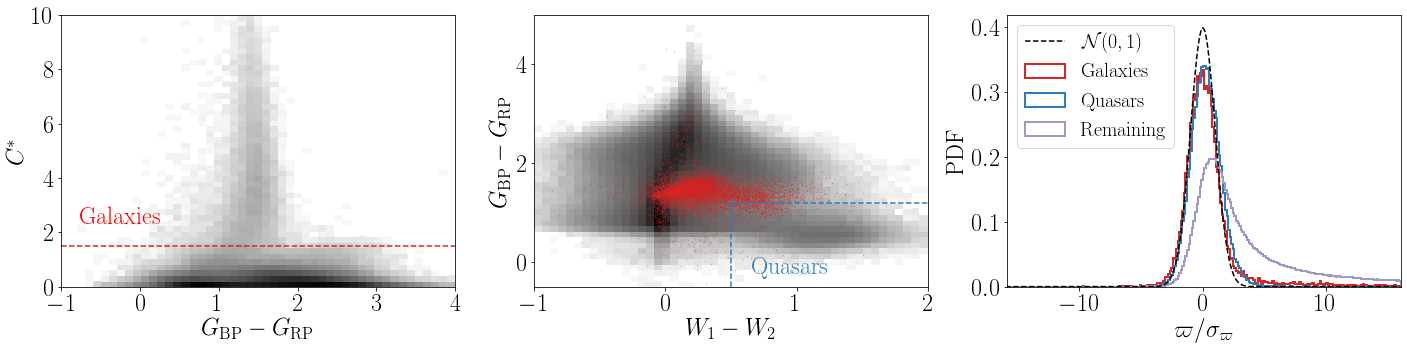

In [141]:
fig, axes = plt.subplots(1,3,figsize=(24,5))

subset = ~np.isnan(data['parallax']) #data['south'] & 

c_gal = cm.Reds(0.7)
c_qso = cm.Blues(0.7)
c_other = cm.Purples(0.5)

plt.sca(axes[0])

lims = [-1,4,0,10]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(data['phot_bp_mean_mag'][subset]-data['phot_rp_mean_mag'][subset], 
                                       data['phot_bp_rp_excess_factor_c'][subset],
                                       data['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic
plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.ylabel(r'$C^*$')

plt.plot([lims[0],lims[1]], [excess_cut,excess_cut], linestyle='--', color=c_gal)

plt.text(lims[1]*0.15+lims[0]*0.85, excess_cut + lims[3]*0.1+lims[2]*0.9, "Galaxies", c='r', ha='center', va='center')


plt.sca(axes[1])

lims = [-1,2,-0.5,5]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(data['w1mpro'][subset]-data['w2mpro'][subset],
                                       data['phot_bp_mean_mag'][subset]-data['phot_rp_mean_mag'][subset], 
                                       data['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.ylabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.xlabel(r'$W_1 - W_2$')

w12cut = [w1w2_cut,lims[1]]
bprpcut = [lims[2],bprp_cut]
plt.plot(w12cut, [bprpcut[1],bprpcut[1]], linestyle='--', color=c_qso)
plt.plot([w12cut[0],w12cut[0]], bprpcut, linestyle='--', color=c_qso)

plt.scatter((data['w1mpro']-data['w2mpro'])[subset&galaxies], 
            (data['phot_bp_mean_mag']-data['phot_rp_mean_mag'])[subset&galaxies],
            s=0.1, alpha=0.5, c=c_gal)

plt.xlim(lims[0], lims[1])
plt.ylim(lims[2], lims[3])

plt.text(w12cut[0]*0.7+lims[1]*0.3, 
         lims[2]*0.85+w12cut[1]*0.15, "Quasars", c=c_qso, ha='center', va='center')


plt.sca(axes[2])

bins = np.linspace(-16,16,251)

plt.hist((data['parallax']/data['parallax_error'])[galaxies], 
             bins=bins, label='Galaxies', histtype='step', density=True, linewidth=2, color=c_gal);
plt.hist((data['parallax']/data['parallax_error'])[quasars], 
             bins=bins, label='Quasars', histtype='step', density=True, linewidth=2, color=c_qso);
plt.hist((data['parallax']/data['parallax_error'])[~(galaxies|quasars)], 
             bins=bins, label='Remaining', histtype='step', density=True, linewidth=2, color=c_other);

plt.plot(bins, scipy.stats.norm.pdf(bins,0,1), '--k', label=r"$\mathcal{N}(0,1)$")

plt.legend(loc='upper left', fontsize=20)
plt.xlim(bins[1], bins[-1])

plt.xlabel(r'$\varpi/\sigma_\varpi$'); plt.ylabel(r'PDF')

plt.savefig('figs/extragalactic_source_filters.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

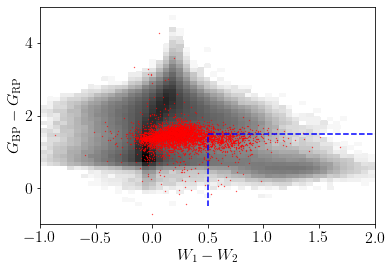

In [35]:
subset = data['north'] & ~np.isnan(data['parallax'])

lims = [-1,2,-0.5,5]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(data['w1mpro'][subset]-data['w2mpro'][subset],
                                       data['phot_bp_mean_mag'][subset]-data['phot_rp_mean_mag'][subset], 
                                       data['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.ylabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.xlabel(r'$W_1 - W_2$')

w12cut = [0.5,lims[1]]
bprpcut = [lims[2],1.5]
plt.plot(w12cut, [bprpcut[1],bprpcut[1]], '--b')
plt.plot([w12cut[0],w12cut[0]], bprpcut, '--b')

plt.scatter((data['w1mpro']-data['w2mpro'])[subset&galaxies], 
            (data['phot_bp_mean_mag']-data['phot_rp_mean_mag'])[subset&galaxies],
            s=0.1, c='r')

Text(0.5, 0, '$W_1 - W_2$')

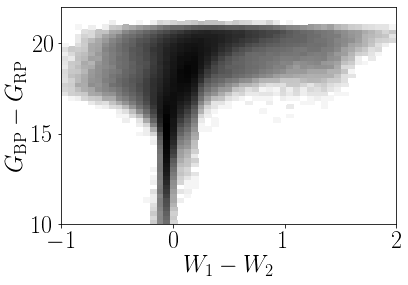

In [143]:
subset = data['north'] & ~np.isnan(data['parallax'])

lims = [-1,2,10.,22.]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(data['w1mpro'][subset]-data['w2mpro'][subset],
                                       data['phot_g_mean_mag'][subset], 
                                       data['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.ylabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.xlabel(r'$W_1 - W_2$')

# w12cut = [0.5,lims[1]]
# bprpcut = [lims[2],1.5]
# plt.plot(w12cut, [bprpcut[1],bprpcut[1]], '--b')
# plt.plot([w12cut[0],w12cut[0]], bprpcut, '--b')

# plt.scatter((data['w1mpro']-data['w2mpro'])[subset&galaxies], 
#             (data['phot_bp_mean_mag']-data['phot_rp_mean_mag'])[subset&galaxies],
#             s=0.1, c='r')

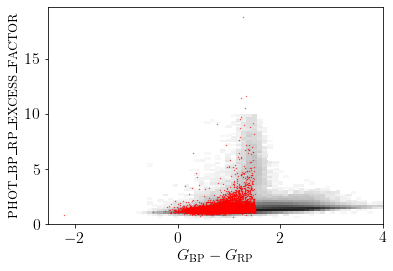

In [226]:
subset = data['south'] & ~np.isnan(data['parallax'])

lims = [-1,4,0,10]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(data['phot_bp_mean_mag'][subset]-data['phot_rp_mean_mag'][subset], 
                                       data['phot_bp_rp_excess_factor'][subset],
                                       data['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.ylabel(r'\textsc{phot\_bp\_rp\_excess\_factor}')

plt.scatter((data['phot_bp_mean_mag']-data['phot_rp_mean_mag'])[subset&quasars],
            (data['phot_bp_rp_excess_factor'])[subset&quasars],
            s=0.1, c='r')

Text(0.5, 0, '$\\varpi/\\sigma_\\varpi$')

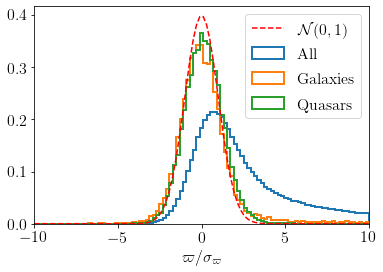

In [227]:
bins = np.linspace(-10,10,100)

plt.hist((data['parallax']/data['parallax_error'])[~(galaxies|quasars)], 
             bins=bins, label='All', histtype='step', density=True, linewidth=2);
plt.hist((data['parallax']/data['parallax_error'])[galaxies], 
             bins=bins, label='Galaxies', histtype='step', density=True, linewidth=2);
plt.hist((data['parallax']/data['parallax_error'])[quasars], 
             bins=bins, label='Quasars', histtype='step', density=True, linewidth=2);

plt.plot(bins, scipy.stats.norm.pdf(bins,0,1), '--r', label=r"$\mathcal{N}(0,1)$")

plt.legend()
plt.xlim(bins[0], bins[-1])

plt.xlabel(r'$\varpi/\sigma_\varpi$')

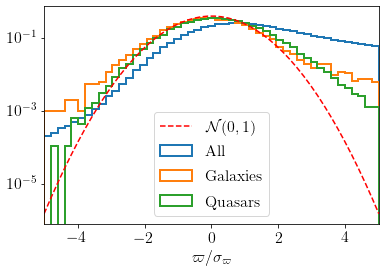

In [179]:
bins = np.linspace(-5,5,50)

plt.hist((data['parallax']/data['parallax_error'])[~(galaxies|quasars)], 
             bins=bins, label='All', histtype='step', density=True, linewidth=2);
plt.hist((data['parallax']/data['parallax_error'])[galaxies], 
             bins=bins, label='Galaxies', histtype='step', density=True, linewidth=2);
plt.hist((data['parallax']/data['parallax_error'])[quasars], 
             bins=bins, label='Quasars', histtype='step', density=True, linewidth=2);

plt.plot(bins, scipy.stats.norm.pdf(bins,0,1), '--r', label=r"$\mathcal{N}(0,1)$")

plt.legend()
plt.xlim(bins[0], bins[-1])

plt.xlabel(r'$\varpi/\sigma_\varpi$')

plt.yscale('log')

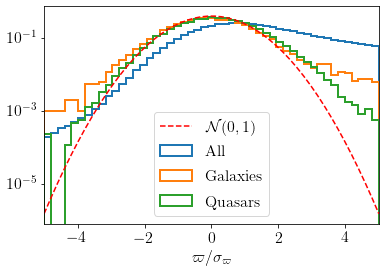

In [228]:
bins = np.linspace(-5,5,50)

plt.hist((data['parallax']/data['parallax_error'])[~(galaxies|quasars)], 
             bins=bins, label='All', histtype='step', density=True, linewidth=2);
plt.hist((data['parallax']/data['parallax_error'])[galaxies], 
             bins=bins, label='Galaxies', histtype='step', density=True, linewidth=2);
plt.hist((data['parallax']/data['parallax_error'])[quasars], 
             bins=bins, label='Quasars', histtype='step', density=True, linewidth=2);

plt.plot(bins, scipy.stats.norm.pdf(bins,0,1), '--r', label=r"$\mathcal{N}(0,1)$")

plt.legend()
plt.xlim(bins[0], bins[-1])

plt.xlabel(r'$\varpi/\sigma_\varpi$')

plt.yscale('log')

In [163]:
len(np.unique(data['source_id'])), len(data['source_id'])

(1847222, 1847230)

# unWISE

In [10]:
undata['phot_bp_rp_excess_factor_c'] = \
undata['phot_bp_rp_excess_factor']-excess_correction(undata['phot_bp_mean_mag']-undata['phot_rp_mean_mag'])

In [12]:
len(np.unique(undata['source_id'])), len(undata['source_id'])

(1847222, 1847222)

In [164]:
len(np.unique(undata['source_id'])), len(undata['source_id'])

(1847222, 1976528)

In [150]:
np.sum(astrometry), len(astrometry)

(1524856, 1976528)

In [23]:
print(f"Fraction WISE: {np.sum(astrometry & (undata['unwise_objid']!='None'))/np.sum(astrometry):.2f}")
print(f"Fraction BPRP: {np.sum(astrometry & (~np.isnan(undata['phot_bp_rp_excess_factor_c'])))/np.sum(astrometry):.2f}")

Fraction WISE: 0.88
Fraction BPRP: 0.99


In [57]:
excess_cut = 1.8
w1w2_cut=0.5
bprp_cut=1.2

galaxies = undata['phot_bp_rp_excess_factor_c']>excess_cut
# galaxies = undata['phot_bp_rp_excess_factor_c']>30*sigma_c(undata['phot_g_mean_mag'])

quasars  = (undata['w1']-undata['w2']>w1w2_cut)&(undata['phot_bp_mean_mag']-undata['phot_rp_mean_mag']<bprp_cut)
#quasars  = (undata['w1']-undata['w2']>w1w2_cut)&((undata['phot_bp_mean_mag']-undata['phot_rp_mean_mag'])<(undata['w1']-undata['w2'])+0.7)
#quasars = (x-2)**2 + (y)**2 < 4
x = undata['w1']-undata['w2']
y = undata['phot_bp_mean_mag']-undata['phot_rp_mean_mag']

astrometry = ~np.isnan(undata['parallax'])

In [58]:
print(f'Galaxies: {np.sum(galaxies&astrometry)}')
print(f'Quasars: {np.sum(quasars&astrometry)}')
print(f'Total filtered: {np.sum((quasars|galaxies)&astrometry)}')
print(f'Expected: {np.sum(astrometry)*0.075:.0f}')

total_expected = 200 * 2 * 2*np.pi * (1-np.sin(np.deg2rad(80))) * (180/np.pi)**2 * np.sum(astrometry/len(astrometry))
print(f'Expected: {total_expected:.0f}')


print(f"Completeness: {np.sum((galaxies|quasars)&astrometry)/total_expected:.2f}")

pos_plx = undata['parallax']/undata['parallax_error']>0
print(f"Quasar purity: {1-(np.sum(quasars&astrometry&pos_plx)-np.sum(quasars&astrometry&~pos_plx))/np.sum(quasars&astrometry):.2f}")
print(f"Galaxy purity: {1-(np.sum(galaxies&astrometry&pos_plx)-np.sum(galaxies&astrometry&~pos_plx))/np.sum(galaxies&astrometry):.2f}")

Galaxies: 10640
Quasars: 47410
Total filtered: 57681
Expected: 107080
Expected: 96880
Completeness: 0.60
Quasar purity: 0.99
Galaxy purity: 0.98


In [59]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)
plt.rc('font',size=24)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


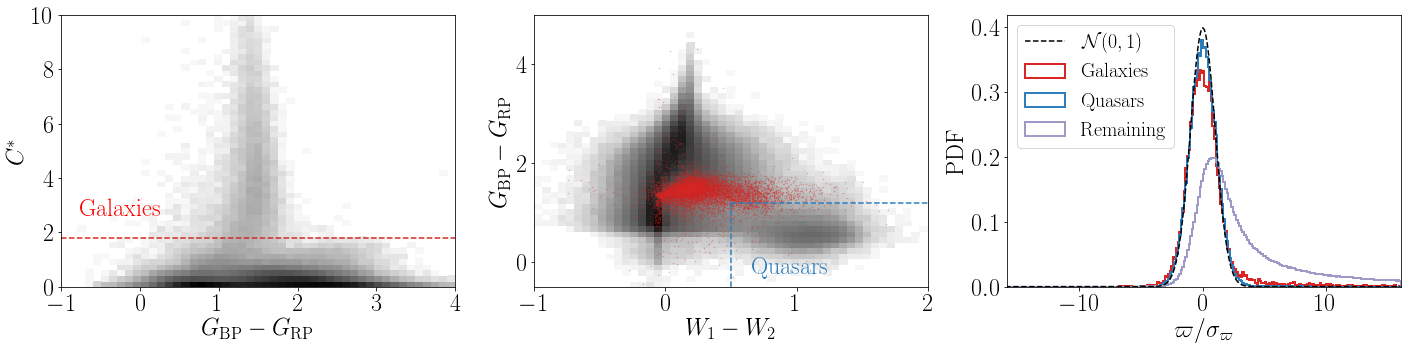

In [61]:
fig, axes = plt.subplots(1,3,figsize=(24,5))

subset = ~np.isnan(undata['parallax']) #undata['south'] & 

c_gal = cm.Reds(0.7)
c_qso = cm.Blues(0.7)
c_other = cm.Purples(0.5)

plt.sca(axes[0])

lims = [-1,4,0,10]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(undata['phot_bp_mean_mag'][subset]-undata['phot_rp_mean_mag'][subset], 
                                       undata['phot_bp_rp_excess_factor_c'][subset],
                                       undata['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic
plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.ylabel(r'$C^*$')

plt.plot([lims[0],lims[1]], [excess_cut,excess_cut], linestyle='--', color=c_gal)

plt.text(lims[1]*0.15+lims[0]*0.85, excess_cut + lims[3]*0.1+lims[2]*0.9, "Galaxies", c='r', ha='center', va='center')


plt.sca(axes[1])

lims = [-1,2,-0.5,5]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(undata['w1'][subset]-undata['w2'][subset],
                                       undata['phot_bp_mean_mag'][subset]-undata['phot_rp_mean_mag'][subset], 
                                       undata['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.ylabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
plt.xlabel(r'$W_1 - W_2$')

w12cut = [w1w2_cut,lims[1]]
plt.plot([w12cut[0],w12cut[0]], bprpcut, linestyle='--', color=c_qso)
bprpcut = [lims[2],bprp_cut]
plt.plot(w12cut, [bprpcut[1],bprpcut[1]], linestyle='--', color=c_qso)
#plt.plot([w1w2_cut,lims[1]],[w1w2_cut+0.7,lims[1]+0.7])


plt.scatter((undata['w1']-undata['w2'])[subset&galaxies], 
            (undata['phot_bp_mean_mag']-undata['phot_rp_mean_mag'])[subset&galaxies],
            s=0.1, alpha=0.5, c=c_gal)

plt.xlim(lims[0], lims[1])
plt.ylim(lims[2], lims[3])

plt.text(w12cut[0]*0.7+lims[1]*0.3, 
         lims[2]*0.85+w12cut[1]*0.15, "Quasars", c=c_qso, ha='center', va='center')


plt.sca(axes[2])

bins = np.linspace(-16,16,251)

plt.hist((undata['parallax']/undata['parallax_error'])[galaxies], 
             bins=bins, label='Galaxies', histtype='step', density=True, linewidth=2, color=c_gal);
plt.hist((undata['parallax']/undata['parallax_error'])[quasars], 
             bins=bins, label='Quasars', histtype='step', density=True, linewidth=2, color=c_qso);
plt.hist((undata['parallax']/undata['parallax_error'])[~(galaxies|quasars)], 
             bins=bins, label='Remaining', histtype='step', density=True, linewidth=2, color=c_other);

plt.plot(bins, scipy.stats.norm.pdf(bins,0,1), '--k', label=r"$\mathcal{N}(0,1)$")

plt.legend(loc='upper left', fontsize=20)
plt.xlim(bins[1], bins[-1])

plt.xlabel(r'$\varpi/\sigma_\varpi$'); plt.ylabel(r'PDF')

plt.savefig('figs/extragalactic_unwise_source_filters.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

In [74]:
np.sum(galaxies|quasars)/len(galaxies)

0.1659232079306115

In [76]:
np.sum(galaxies), np.sum(quasars)

(241973, 73511)

In [79]:
MG_cut = (spec['parallax']-spec['parallax_error'] < 10**((22-spec['phot_g_mean_mag'])/5))

In [80]:
eg_source = galaxies|quasars
print(np.sum(eg_source), np.sum(MG_cut))
print(np.sum(eg_source&MG_cut), np.sum(~eg_source&MG_cut), np.sum(eg_source&~MG_cut))

306497 1398628
60560 1338068 245937


In [ ]:
(sample['parallax_obs']-sample['parallax_error'] < 10**((22-sample['m'])/5)) & (sample['m']>5) & (sample['m']<22)

In [99]:
query = """select * from andy_everall.gaia_unwise_sdss_b80"""

%time wise_sdss = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

wise_sdss['w1'] = 22.5-2.5*np.log10(undata['flux_w1'])
wise_sdss['w2'] = 22.5-2.5*np.log10(undata['flux_w2'])

CPU times: user 20.8 s, sys: 3.19 s, total: 24 s
Wall time: 1min 44s


In [105]:
wise_sdss['phot_bp_rp_excess_factor_c'] = \
wise_sdss['phot_bp_rp_excess_factor']-excess_correction(wise_sdss['phot_bp_mean_mag']-wise_sdss['phot_rp_mean_mag'])

In [106]:
len(np.unique(undata['source_id'])), len(undata['source_id'])

(1847222, 1847222)

In [108]:
print(f"Fraction WISE: {np.sum(astrometry & (wise_sdss['unwise_objid']!='None'))/np.sum(astrometry):.2f}")
print(f"Fraction SDSS: {np.sum(astrometry & (wise_sdss['objid']!='None'))/np.sum(astrometry):.2f}")
print(f"Fraction BPRP: {np.sum(astrometry & (~np.isnan(wise_sdss['phot_bp_rp_excess_factor_c'])))/np.sum(astrometry):.2f}")

Fraction WISE: 0.88
Fraction SDSS: 1.00
Fraction BPRP: 0.99


In [109]:
excess_cut = 1.8
w1w2_cut=0.5
bprp_cut=1.2

galaxies = undata['phot_bp_rp_excess_factor_c']>excess_cut
# galaxies = undata['phot_bp_rp_excess_factor_c']>30*sigma_c(undata['phot_g_mean_mag'])

quasars  = (undata['w1']-undata['w2']>w1w2_cut)&(undata['phot_bp_mean_mag']-undata['phot_rp_mean_mag']<bprp_cut)
#quasars  = (undata['w1']-undata['w2']>w1w2_cut)&((undata['phot_bp_mean_mag']-undata['phot_rp_mean_mag'])<(undata['w1']-undata['w2'])+0.7)
#quasars = (x-2)**2 + (y)**2 < 4
x = undata['w1']-undata['w2']
y = undata['phot_bp_mean_mag']-undata['phot_rp_mean_mag']

astrometry = ~np.isnan(undata['parallax'])

In [110]:
print(f'Galaxies: {np.sum(galaxies&astrometry)}')
print(f'Quasars: {np.sum(quasars&astrometry)}')
print(f'Total filtered: {np.sum((quasars|galaxies)&astrometry)}')
print(f'Expected: {np.sum(astrometry)*0.075:.0f}')

total_expected = 200 * 2 * 2*np.pi * (1-np.sin(np.deg2rad(80))) * (180/np.pi)**2 * np.sum(astrometry/len(astrometry))
print(f'Expected: {total_expected:.0f}')


print(f"Completeness: {np.sum((galaxies|quasars)&astrometry)/total_expected:.2f}")

pos_plx = wise_sdss['parallax']/wise_sdss['parallax_error']>0
print(f"Quasar purity: {1-(np.sum(quasars&astrometry&pos_plx)-np.sum(quasars&astrometry&~pos_plx))/np.sum(quasars&astrometry):.2f}")
print(f"Galaxy purity: {1-(np.sum(galaxies&astrometry&pos_plx)-np.sum(galaxies&astrometry&~pos_plx))/np.sum(galaxies&astrometry):.2f}")

Galaxies: 10640
Quasars: 47410
Total filtered: 57681
Expected: 107080
Expected: 96880
Completeness: 0.60
Quasar purity: 0.99
Galaxy purity: 0.98


In [ ]:
print(f"Completeness Galaxies: {np.sum(galaxies&spec_gal&astrometry)/np.sum(spec_gal&astrometry):.2f}")
print(f"Completeness Galaxies: {np.sum(quasars&spec_qso&astrometry)/np.sum(spec_qso&astrometry):.2f}")

pos_plx = wise_sdss['parallax']/wise_sdss['parallax_error']>0
print(f"Quasar purity: {1-(np.sum(quasars&astrometry&pos_plx)-np.sum(quasars&astrometry&~pos_plx))/np.sum(quasars&astrometry):.2f}")
print(f"Galaxy purity: {1-(np.sum(galaxies&astrometry&pos_plx)-np.sum(galaxies&astrometry&~pos_plx))/np.sum(galaxies&astrometry):.2f}")

(-3.0, 5.0)

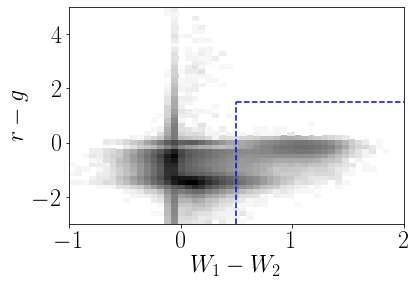

In [132]:
subset = ~np.isnan(wise_sdss['parallax'])

s1,s2 = ['r','g']

lims = [-1,2,-3,5]
x_bins, y_bins = np.linspace(lims[0],lims[1],50),np.linspace(lims[2],lims[3],50)
hist = scipy.stats.binned_statistic_2d(wise_sdss['w1'][subset]-wise_sdss['w2'][subset],
                                       wise_sdss[s1][subset]-wise_sdss[s2][subset], 
                                       wise_sdss['source_id'][subset],
                                       bins=(x_bins, y_bins), statistic='count').statistic

plt.pcolor(x_bins, y_bins, hist.T, cmap='Greys', norm=LogNorm())
plt.ylabel(fr'${s1}-{s2}$')
plt.xlabel(r'$W_1 - W_2$')

w12cut = [0.5,lims[1]]
bprpcut = [lims[2],1.5]
plt.plot(w12cut, [bprpcut[1],bprpcut[1]], '--b')
plt.plot([w12cut[0],w12cut[0]], bprpcut, '--b')

# plt.scatter((wise_sdss['w1']-wise_sdss['w2'])[subset&galaxies], (wise_sdss[s1]-wise_sdss[s2])[subset&galaxies], s=0.1, c='r')

plt.xlim(lims[0],lims[1]); plt.ylim(lims[2],lims[3])

In [98]:
query = """select ra, dec from sdssdr14.specobjall"""

%time sdss = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 5.26 s, sys: 1.23 s, total: 6.5 s
Wall time: 53.6 s


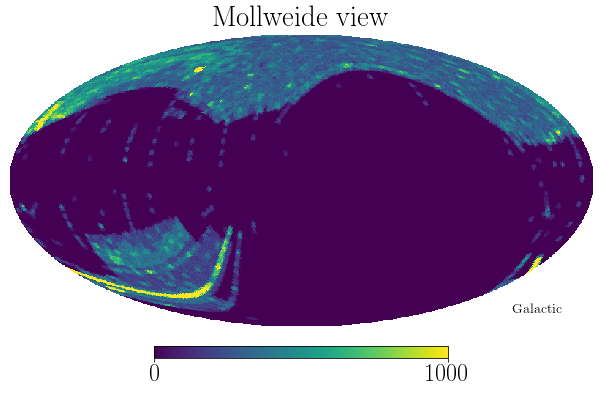

In [104]:
hpix = hp.ang2pix(64, sdss['ra'], sdss['dec'], lonlat=True)

arr = np.zeros(hp.nside2npix(64), dtype=int)
arr[np.unique(hpix)] = np.unique(hpix, return_counts=True)[1]
#arr[arr==0] = 1

hp.mollview(arr, max=1000, coord=['C','G'])

In [25]:
query = """select source_id from wise.main 
            where glat>80
            limit 1000"""
%time wise = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 4min 6s


In [26]:
wise['source_id']

array(['1871p181_ab41-037329', '1871p181_ab41-037203',
       '1871p181_ab41-037727', '1871p181_ab41-037391',
       '1871p181_ab41-037747', '1871p181_ab41-037389',
       '1871p181_ab41-037395', '1871p181_ab41-037608',
       '1871p181_ab41-037644', '1871p181_ab41-037374',
       '1871p181_ab41-038024', '1871p181_ab41-037612',
       '1871p181_ab41-037829', '1871p181_ab41-037288',
       '1871p181_ab41-037833', '1871p181_ab41-037547',
       '1871p181_ab41-037542', '1871p181_ab41-037579',
       '1871p181_ab41-037223', '1871p181_ab41-037683',
       '1871p181_ab41-037349', '1871p181_ab41-037775',
       '1871p181_ab41-037418', '1871p181_ab41-037273',
       '1871p181_ab41-037642', '1871p181_ab41-038048',
       '1871p181_ab41-037592', '1871p181_ab41-037669',
       '1871p181_ab41-037471', '1871p181_ab41-037848',
       '1871p181_ab41-037632', '1871p181_ab41-037439',
       '1871p181_ab41-037279', '1871p181_ab41-037161',
       '1871p181_ab41-037708', '1871p181_ab41-037474',
       '18

In [14]:
data.keys()

odict_keys(['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'wise_sid', 'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro', 'phot_bp_rp_excess_factor', 'phot_bp_rp_excess_factor_c'])

In [16]:
data['wise_sid']

array(['None', '0093m364_a', 'None', ..., 'None', '1995p363_a',
       '1995p363_a'], dtype='<U10')

In [19]:
wise['source_id']

array(['0000m016_ab41-000001', '0000m016_ab41-000004',
       '0000m016_ab41-000005', '0000m016_ab41-000006',
       '0000m016_ab41-000007', '0000m016_ab41-000010',
       '0000m016_ab41-000011', '0000m016_ab41-000012',
       '0000m016_ab41-000013', '0000m016_ab41-000014',
       '0000m016_ab41-000015', '0000m016_ab41-000016',
       '0000m016_ab41-000017', '0000m016_ab41-000018',
       '0000m016_ab41-000019', '0000m016_ab41-000021',
       '0000m016_ab41-000022', '0000m016_ab41-000023',
       '0000m016_ab41-000024', '0000m016_ab41-000025',
       '0000m016_ab41-000028', '0000m016_ab41-000030',
       '0000m016_ab41-000032', '0000m016_ab41-000033',
       '0000m016_ab41-000034', '0000m016_ab41-000035',
       '0000m016_ab41-000036', '0000m016_ab41-000038',
       '0000m016_ab41-000039', '0000m016_ab41-000040',
       '0000m016_ab41-000041', '0000m016_ab41-000043',
       '0000m016_ab41-000044', '0000m016_ab41-000046',
       '0000m016_ab41-000047', '0000m016_ab41-000048',
       '00

In [76]:
query = """select * from andy_everall.gaia_wise_b80"""

%time test= sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 12.8 s, sys: 2.34 s, total: 15.1 s
Wall time: 1min 33s


In [ ]:
test['wise_sid']

In [165]:
query = """select * from gaia_dr2.gaia_source
            where source_id=1362295082910131200"""
%time source = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 542 ms


In [168]:
query = """select * from gaia_dr2.ruwe
            where source_id=1362295082910131200"""
%time ruwe = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 568 ms


In [169]:
ruwe

OrderedDict([('source_id', array([1362295082910131200])),
             ('ruwe', array([0.93888915], dtype=float32))])

In [167]:
source['ruwe']

KeyError: 'ruwe'